# Topic diversity exploration

In [2]:
%pip install datasets pandas psycopg2 python-dotenv torch transformers scikit-learn sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.7-cp311-cp311-macosx_13_0_arm64.whl size=145718 sha256=85b29805d9ccc8eb7427d9c9d3ccb024af27b68598c5f0ebb00d33c200a277ac
  Stored in directory: /Users/ritsuko/Library/Caches/pip/wheels/ca/a2/1f/9f85470e2065e7a4089baa6c47cfa57a2f8f8e78e07390c5b4
Successfully built psycopg2
Note: you may need to restart the kernel to use updated packages.


## Source in dataset for first time

This is optional; consider saving the DF to your filesystem to avoid this

In [2]:
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import os

load_dotenv()

# Make sure there's a .env file with PG_URL set to connection string!
# Note for the unwary: make sure to restart the kernel if you change this.
# Don't ask me how I know.
engine = create_engine(os.getenv("PG_URL"))

In [3]:
df = pd.read_sql("SELECT * FROM items WHERE title IS NOT NULL AND score >= 20;", engine)

In [4]:
df.to_parquet("datasets/raw-story-data.parquet")

## Creating title embeddings

In [5]:
import pandas as pd
df = pd.read_parquet("datasets/raw-story-data.parquet")

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-base-en-v1.5')
model = AutoModel.from_pretrained("BAAI/bge-base-en-v1.5")


/Users/ritsuko/projects/ai/nlp/instruct-hn/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# device = "cuda"
device = "mps"
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

All right, now let's get an embedding function:

In [8]:
df = df[df['title'].notnull()]

In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [10]:
def generate_embeddings(batch):
    """Generate embeddings for a batch of data."""
    inputs = tokenizer(batch['title'], padding=True, truncation=True, return_tensors='pt', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs[0][:, 0]
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
    # Convert to numpy array on CPU
    return {'embeddings': embeddings.cpu().numpy(), 'uid': batch['id']}

In [11]:
# Generate embeddings
# Building this in memory is fine since it's only 97k 768-dimensional embeddings and I have a bunch of RAM
dataset_with_embeddings = dataset.map(generate_embeddings, batched=True, batch_size=128)

Map: 100%|██████████| 450733/450733 [11:40<00:00, 643.27 examples/s]


In [12]:
df = dataset_with_embeddings.to_pandas()

In [13]:
df.to_parquet("datasets/posts-title-embed-solo-bge.parquet")

## K-means clustering

In [2]:
import pandas as pd
import numpy as np
df = pd.read_parquet("datasets/posts-title-embed-solo-bge.parquet")
df['embeddings'] = df['embeddings'].apply(lambda x: np.array(x, dtype='float32'))

Let's, totally ad-hoc, start us off with some random hyperparameters because I am tired and want to go to bed.

Training on 10k random titles and 10 clusters to just validate the pipeline, I will test and optimize tomorrow.

In [56]:
np.random.seed(42)

df_train_sample = df.sample(n=25_000, random_state=42)

In [1]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for numba>=0.51.2 from https://files.pythonhosted.org/packages/ce/eb/c982ad64cc2a4cc0a6b95ea94da5566874a6eaffc585c789ef2dd77fc06a/numba-0.57.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.9 MB/s eta 0:00:00a 0:00:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for llvmlite<0.41,>=0.40.0dev0 from https://files.pythonhosted.org/packages/d3/fe/14ad307b173df79e8792f253c67e9edde6aefa00b25de031863662d223b4/llvmlite-0.40.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numpy>=1.17 from https://files.pythonhosted.org/packages/c0/bc/7

In [57]:
train_emb_array = np.array(df_train_sample["embeddings"].tolist())

In [120]:
import umap.umap_ as umap

# Reduce dimensionality of train_emb_array using UMAP to 3 dimensions
reducer = umap.UMAP(n_components=48, n_jobs=-1)
train_emb_reduced = reducer.fit_transform(train_emb_array)

In [121]:
from sklearn.cluster import MiniBatchKMeans

silhouette_avgs = {}
db_scores = {}

# Powers of 2 of k values to try
k_values = [2**i for i in range(1, 10)]

from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

for n_clusters in k_values:
    # Initialize MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init="auto")
    
    # Fit the model
    kmeans = kmeans.fit(train_emb_reduced)
    
    # Get cluster labels
    labels_sample = kmeans.labels_
    
    # Compute Davies-Bouldin score
    db_score = davies_bouldin_score(train_emb_reduced, labels_sample)

    """
    print("Silhouette scores per cluster:")
    for label, score in silhouette_dict.items():
     # Get score for each sample
    silhouette_vals = silhouette_samples(train_emb_reduced, labels_sample, metric='cosine')

    # Save silhouette score for each cluster
    silhouette_dict = {}
    for label in np.unique(labels_sample):
        label_silhouette_vals = silhouette_vals[labels_sample == label]
        silhouette_dict[label] = label_silhouette_vals.mean()

       print(f"Cluster {label}: {score}")
    """
    # Compute silhouette score
    silhouette_avg = silhouette_score(train_emb_reduced, labels_sample, metric='cosine', n_jobs=-1)

    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    print(f"The average Davies-Bouldin score is: {db_score }")
    
    # Store silhouette_avg in dictionary
    silhouette_avgs[n_clusters] = silhouette_avg
    db_scores[n_clusters] = db_score
    

For n_clusters = 2, the average silhouette_score is : 0.4787771999835968
The average Davies-Bouldin score is: 1.2685043612238172
For n_clusters = 4, the average silhouette_score is : 0.4150114953517914
The average Davies-Bouldin score is: 1.3460959211902772
For n_clusters = 8, the average silhouette_score is : 0.37684765458106995
The average Davies-Bouldin score is: 1.4081422495395217
For n_clusters = 16, the average silhouette_score is : 0.34820878505706787
The average Davies-Bouldin score is: 1.3137422701061676
For n_clusters = 32, the average silhouette_score is : 0.3958350121974945
The average Davies-Bouldin score is: 1.2222185799278482
For n_clusters = 64, the average silhouette_score is : 0.3969081938266754
The average Davies-Bouldin score is: 1.2724122453943152
For n_clusters = 128, the average silhouette_score is : 0.39573198556900024
The average Davies-Bouldin score is: 1.2456812028553144
For n_clusters = 256, the average silhouette_score is : 0.4027732312679291
The average Da

In [ ]:
%pip install matplotlib

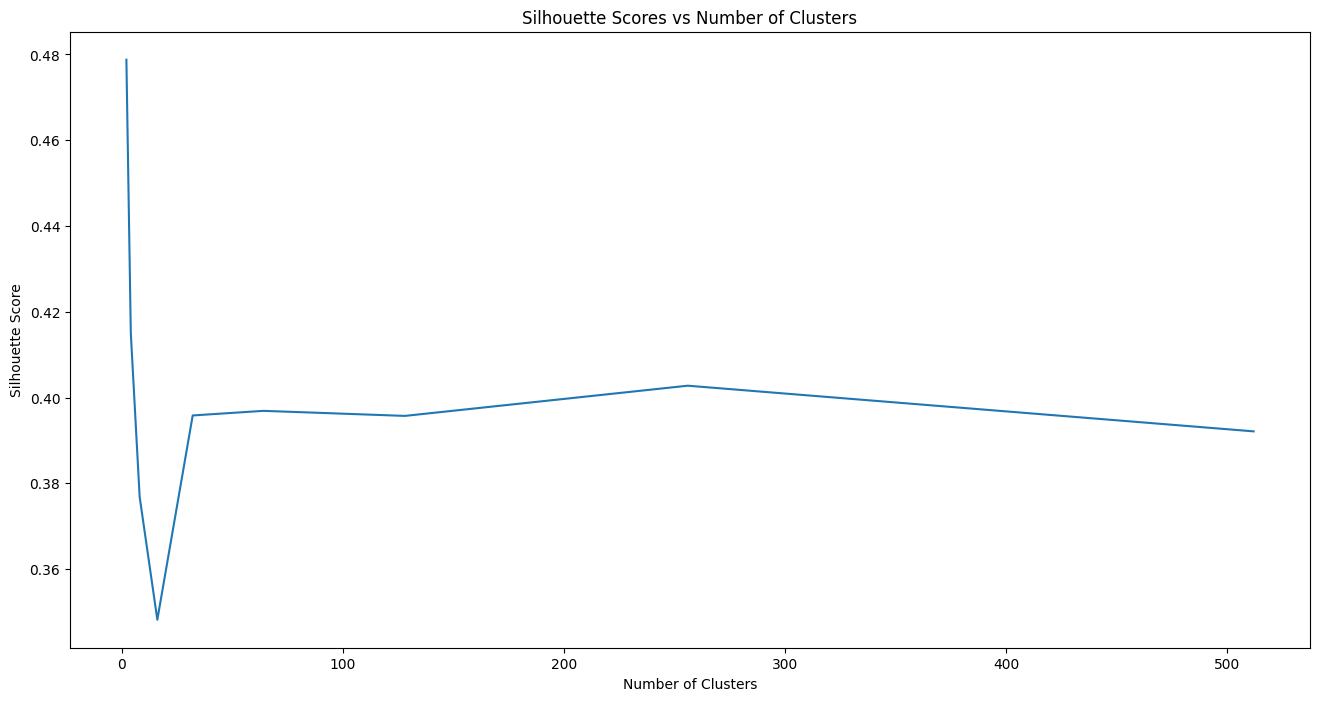

In [122]:
import matplotlib.pyplot as plt

# Plotting the silhouette scores
plt.figure(figsize=(16, 8))
plt.plot(list(silhouette_avgs.keys()), list(silhouette_avgs.values()))
plt.title("Silhouette Scores vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [133]:
n_clusters=512

In [134]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init="auto")

kmeans = kmeans.fit(train_emb_reduced)

Optional: Remove duplicate columns. Idempotent if not

In [10]:
# Remove duplicates
# Drop columns ending with '_y'
columns_to_drop = [col for col in df.columns if col.endswith('_y')]
df.drop(columns=columns_to_drop, inplace=True)

# Rename columns ending with '_x' to remove the suffix
columns_to_rename = {col: col.rstrip('_x') for col in df.columns if col.endswith('_x')}
df.rename(columns=columns_to_rename, inplace=True)


In [125]:
import numpy as np

embeddings_matrix = reducer.transform(np.stack(df["embeddings"].to_numpy()).astype(np.float32))

In [135]:
df["title_cluster"] = kmeans.predict(embeddings_matrix)
df["title_cluster"].value_counts()

title_cluster
55     4517
323    3758
326    2872
151    2856
163    2773
       ... 
411     141
188     137
249     136
290     117
179      76
Name: count, Length: 512, dtype: int64

In [172]:
# Function to print 5 representative titles for each cluster
def print_representative_titles(df, cluster_col='title_cluster', title_col='title'):
    unique_clusters = df[cluster_col].unique()
    
    for cluster in unique_clusters:
        representative_titles = df[df[cluster_col] == cluster][title_col].sample(7, replace=True).tolist()
        print(f"Cluster {cluster} Representative Titles:")
        for title in representative_titles:
            print(f"  - {title}")

print_representative_titles(df)

Cluster 456 Representative Titles:
  - Lessons I’ve Learned from Three Million App Downloads
  - Hipmunk for iPhone
  - Hipmunk for iPhone
  - How iOS 9's Safari View Controller could change your app’s onboarding experience
  - Hasura – A Batteries-included App Development Platform
  - Mobile Web App Checklist
  - Ask HN: How is Facebook's iOS app 491MB?
Cluster 115 Representative Titles:
  - Ask HN: Who is Hiring? (April 2011)
  - Who Needs a Boss?
  - John Carmack on Hiring
  - Ask HN: Who Is Hiring? (December 2012)
  - Ask HN: Senior Positions Interview Prep Resources?
  - Ask HN: How early did you bring in a full-time marketer?
  - Ask HN: Who is hiring? (March 2014)
Cluster 476 Representative Titles:
  - Launch HN: Heimdal (YC S21) – Carbon neutral cement
  - Indie Game Developer Finds Success On Xbox 360 -- Est. $825K Sales In First Week
  - Saving 80% in 90 Seconds?
  - Notion Acquires Cron
  - How Etsy Prepared for Historic Volumes of Holiday Traffic in 2020
  - How an app deve

## Topic modeling

Can we make these clusters more legible? Copy-pasting from Maarten Grootendorst's [c-TF-IDF](https://www.maartengrootendorst.com/blog/ctfidf/) (though not the whole BERTopic skeleton yet):

In [138]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """
        n_samples: Number of unjoined documents.

        Learn the idf vector (global term weights) 
        """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

Let's apply this to the whole fucking set:

In [155]:
# Concat all docs per class in train set
docs_per_class_train = df.groupby('title_cluster', as_index=False).agg({'title': ' '.join})

# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class_train.title)
count = count_vectorizer.transform(docs_per_class_train.title)
words = count_vectorizer.get_feature_names_out()

# Create c-tfidf vectorizer
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs_per_class_train))

OK, let's see some of the results:

In [165]:
ctfidf_arr = ctfidf.toarray()
words_per_cluster = [[words[index] for index in ctfidf_arr[cluster].argsort()[-10:]] for cluster in range(n_clusters)]

In [176]:
cluster_counts = df["title_cluster"].value_counts()
cluster_counts.sort_index(inplace=True)
cluster_df = pd.DataFrame({"cluster": cluster_counts.index, "count": cluster_counts.values, "top_words": [", ".join(x) for x in words_per_cluster]})
cluster_df.sort_values("count", ascending=False, inplace=True)
cluster_df.head(20)

,cluster,count,top_words
55,55,4517,"delete, ftc, likes, misinformation, metaverse,..."
323,323,3758,"entrepreneurial, chile, founding, fundraising,..."
326,326,2872,"mailgun, webmail, mailbox, spam, smtp, mailchi..."
151,151,2856,"clang, iso, pascal, std, pointers, undefined, ..."
163,163,2773,"wallets, dogecoin, icos, miners, currencies, n..."
58,58,2595,"sqlalchemy, cockroachdb, migrations, mariadb, ..."
350,350,2418,"multiverse, schrödinger, gravity, qubit, physi..."
5,5,2368,"gigs, contracting, consultant, profitable, pas..."
464,464,2360,"immunity, antibody, outbreak, variant, vaccina..."
379,379,2284,"portfolio, frequency, traders, warren, investi..."


In [177]:
cluster_df.to_csv("datasets/title-cluster-top-words.csv", index=False)

In [188]:
cluster_407_df = df[df["title_cluster"]== 407][["score", "url", "title"]]
cluster_407_df.sort_values("score", ascending=False, inplace=True)
cluster_407_df.head(50)

,score,url,title
425181,1273,https://github.com/donnemartin/system-design-p...,Learn how to design large-scale systems
424108,945,https://robertheaton.com/2020/04/06/systems-de...,Systems Design for Advanced Beginners
423859,906,https://jenson.org/tesla/,A UX designer walks into a Tesla Bar
423492,856,https://www.stephanboyer.com/post/134/my-unusu...,My unusual hobby
421847,715,https://woodgears.ca/,Woodworking for Engineers
419856,623,https://www.fast.design/docs/introduction,Microsoft Fast Design
419680,617,http://blog.system76.com/post/159767214983/ent...,System76 is moving product design and manufact...
419024,594,https://constructionphysics.substack.com/p/how...,How to design a house to last 1000 years
417327,544,https://github.com/dair-ai/Prompt-Engineering-...,"Prompt Engineering Guide: Guides, papers, and ..."
416798,531,https://www.google.com/atap/project-jacquard/,Project Jacquard


In [171]:
df["title_cluster"].value_counts()

title_cluster
55     4517
323    3758
326    2872
151    2856
163    2773
       ... 
411     141
188     137
249     136
290     117
179      76
Name: count, Length: 512, dtype: int64

In [65]:
df_silhouette_sample = df.sample(n=10_000, random_state=64)

X_sample = np.stack(df_silhouette_sample['embeddings'].values)
labels_sample = df_silhouette_sample['title_cluster'].values

Wow, this is useless.

In [22]:
import pickle
pkl_fname = "title-kmeans.pkl"
with open(pkl_fname, 'wb') as file:
    pickle.dump(kmeans, file)

In [ ]:
"""
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
"""

## Sheer utter boredom

let's predict the HN post score in the dumbest way possible.

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [72]:
bins = [0, 32, 64, 128, 256, 512, 1024, 2048, float('inf')]
labels = ['0-32', '32-64', '64-128', '128-256', '256-512', '512-1024', '1024-2048', '2048+']

df['score_range'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)
df['score_label'] = df['score_range'].astype('category').cat.codes


In [73]:
df["score_label"].value_counts()

score_label
1    126513
2    112603
0     86444
3     79324
4     34975
5      9261
6      1455
7       158
Name: count, dtype: int64

In [128]:
# Separate the data by 'score_label'
grouped = df.groupby('score_label')

# Determine the number of samples to draw from each group to balance them
# Here, we aim to match the 80% size of the smallest group (bucket 7)
target_size = int(0.8 * grouped.size().min())

# Sample from each group
sampled_dfs = [group.sample(target_size, replace=True) for _, group in grouped]

# Combine the sampled data to create a balanced training set
balanced_df = pd.concat(sampled_dfs, ignore_index=True)


embeddings = np.array(balanced_df["embeddings"].tolist())
labels = balanced_df["score_label"].values

In [141]:
import torch

X = torch.tensor(embeddings, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

In [142]:
from torch.utils.data import DataLoader, TensorDataset
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [132]:
import torch.nn as nn

# Define the model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.fc(x)

In [150]:
import torch.optim as optim
# Initialize the model, loss, and optimizer
model = SimpleClassifier(X_train.shape[1], len(bins) - 1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [143]:
y_train.shape

torch.Size([806])

In [151]:
# Training loop
for epoch in range(10):  # 10 epochs as an example
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch}, Loss: {loss.item()}")



Epoch 0, Loss: 2.093410015106201
Epoch 1, Loss: 1.9829645156860352
Epoch 2, Loss: 2.014063835144043
Epoch 3, Loss: 1.9200794696807861
Epoch 4, Loss: 1.9282312393188477
Epoch 5, Loss: 1.9511048793792725
Epoch 6, Loss: 2.049727439880371
Epoch 7, Loss: 1.81847083568573
Epoch 8, Loss: 2.116856336593628
Epoch 9, Loss: 1.804591178894043


In [91]:
len(bins)

9

In [152]:
# DataLoader for test set
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model
correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        # Forward pass
        outputs = model(batch_X)
        
        # Get the index of the highest score in the output tensor
        _, predicted = torch.max(outputs.data, 1)
        
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 16.83%


In [153]:
# Assuming 'model' is your trained PyTorch model and 'df' is your DataFrame

# Convert embeddings to PyTorch tensor
embeddings = torch.tensor(df['embeddings'].tolist(), dtype=torch.float32)

# DataLoader
data_loader = DataLoader(embeddings, batch_size=2048, shuffle=False)

# Store predictions
predictions = []

# Evaluate
with torch.no_grad():
    for batch_X in data_loader:
        # Forward pass
        outputs = model(batch_X)
        
        # Get the index of the highest score in the output tensor
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.tolist())

# Add predictions to DataFrame
df['predicted_label'] = predictions


In [154]:
# Create a new boolean column that is True if the predicted and actual labels match, otherwise False
df['is_correct'] = df['score_label'] == df['predicted_label']

# Group by the cluster ID and calculate both the mean and count of 'is_correct' for each group
cluster_stats = df.groupby('title_cluster')['is_correct'].agg(['mean', 'count'])

# Rename columns for better understanding
cluster_stats.columns = ['mean_accuracy', 'count']

# Sort the DataFrame if needed
cluster_stats = cluster_stats.sort_values(by=['count', 'mean_accuracy'], ascending=[False, False])

In [118]:
cluster_stats.to_csv("datasets/cluster_stats_128")

In [155]:
# Group by the actual score label bins and calculate the mean accuracy for each group
score_bin_stats = df.groupby('score_label')['is_correct'].agg(['mean', 'count'])

# Sort the DataFrame based on mean accuracy or count as you prefer
score_bin_stats = score_bin_stats.sort_values(by=['mean', 'count'], ascending=[False, False])

# Rename columns for better understanding
score_bin_stats.columns = ['mean_accuracy', 'count']
score_bin_stats

,mean_accuracy,count
score_label,,
6,0.426117,1455
7,0.316456,158
1,0.239912,126513
0,0.148350,86444
3,0.132595,79324
5,0.092107,9261
4,0.083145,34975
2,0.079634,112603
